In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
import os
from netCDF4 import Dataset

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [18]:
# Import and apply style file for plots
plt.style.use("mpl.style")

## System properties

In [19]:
#In LJ units

#System dimensions
d = 3

#Smoothing length coefficient
h3 = 3.5

#System size
L_x = 10 #Size of the system
L_y = L_x
#L_z = h3*(d-2)*sf

#Fluid properties
eta = 0.01
rho = 1
nu = eta/rho

#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x
k_y = 2*np.pi/L_y

#Decay timescale
tau = 1/nu/(k_x**2+k_y**2)

## Functions

Calculate velocity from analytical solution to Taylor-Green Vortex

In [20]:
#This expression returns the magnitude of velocity vectors only
def vel_x_y_t(x,y,t,k_x,k_y,tau):
    u_x = u_0*np.cos(k_x*x)*np.sin(k_y*y)
    u_y = u_0*np.sin(k_x*x)*np.cos(k_y*y)
    u_t = np.exp(-t/tau)
    return np.sum(np.abs(u_x), axis=1)*u_t , np.sum(np.abs(u_y), axis=1)*u_t

Take a folder filepath as an input and return a dictionary containing the filepaths of each file in that folder (value) and a tuple of run properties (key)

In [21]:
#Compile all filenames (value) and properties (key) into a dictionary
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        #Collect the info for the run in an array
        file_info = file.split(".")
        file_info = file_info[0].split("_")

        #File name
        file_name = file

        #Add the files to datafiles dictionary
        data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name
    return data_files

Multipurpose function that will:
 * Retrieve data from array of file names
 * Plot decay of ln(KE) vs t
 * Calculate error in viscosity vs analytical solution

In [22]:
def benchmark_runs(data_files):
    fig = plt.figure()

    all_run_info = []

    for run in data_files:
        run_info = list(run)[0:2]
        ds = Dataset(data_files[run])

        #Scaling variables
        sf = 1/int(list(run)[2]) #Scaling of unit cell
        L_z = h3*(d-2)*sf #Account for L_z if d=3
        n = 1/sf**d #Number density - number of particles per volume
        
        if d == 3:
            N = L_x*L_y*L_z/sf**d # Total number of atoms
        elif d == 2:
            N = L_x*L_y/sf**d 
        
        mp = rho/n #Mass of particles (density is constant)

        run_info.append(sf)

        #Kinetic energy from data
        td = ds["time"][:]
        print(len(td))
        print(max(td),min(td))
        xd = ds['coordinates'][:,:,0] #At timestep nf, for all particles, x position
        yd = ds["coordinates"][:,:,1] #At timestep nf, for all particles, y position
        vxd = ds["velocities"][:,:,0] #At timestep nf, for all particles, x position
        vyd = ds['velocities'][:,:,1] #At timestep nf, for all particles, y velocity
        Exd = 0.5*mp*(np.sum(np.abs(vxd), axis=1))**2
        Eyd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
        E_tot = (Exd+Eyd)/N


        #Viscosity calculation from slope of semilogy(E_tot vs t)
        slope_d = linregress(td, np.log(E_tot))[0]
        nu_d = -slope_d/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data

        #Kinetic energy from analytic solution
        ref_vx, ref_vy = vel_x_y_t(xd,yd,td,k_x,k_y,tau)
        ref_Ex = 0.5*mp*(ref_vx)**2
        ref_Ey = 0.5*mp*(ref_vy)**2
        ref_E_tot = (ref_Ex + ref_Ey)/N

        #Viscosity calculation from analytical solution
        slope_ref = linregress(td, np.log(ref_E_tot))[0]
        nu_ref = -slope_ref/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data

        #Error
        nu_error = np.abs(nu_ref-nu_d)
        run_info.append(nu_error)

        all_run_info.append(run_info)

        plt.semilogy(td, E_tot, label = run_info[0:3])

    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.ylabel(r"$\log{(\frac{KE_{tot}}{N})}$")
    plt.xlabel("t")

    return all_run_info

51
29.1666666666667 0.0
51
58.3333333333333 0.0
51
29.1666666666667 0.0
51
58.3333333333333 0.0
51
145.833333333333 0.0
244
708.7499999999984 0.0
  Shifting RK   sf  Viscosity Error
0        1  1  0.1         0.000268
3        1  1  0.2         0.002200
5        1  1  0.5         0.001402
  Shifting RK   sf  Viscosity Error
2        0  0  0.1         0.018096
1        0  0  0.2         0.029743
4        0  0  0.5         0.035190


Text(0.5, 0, '${\\Delta x}$')

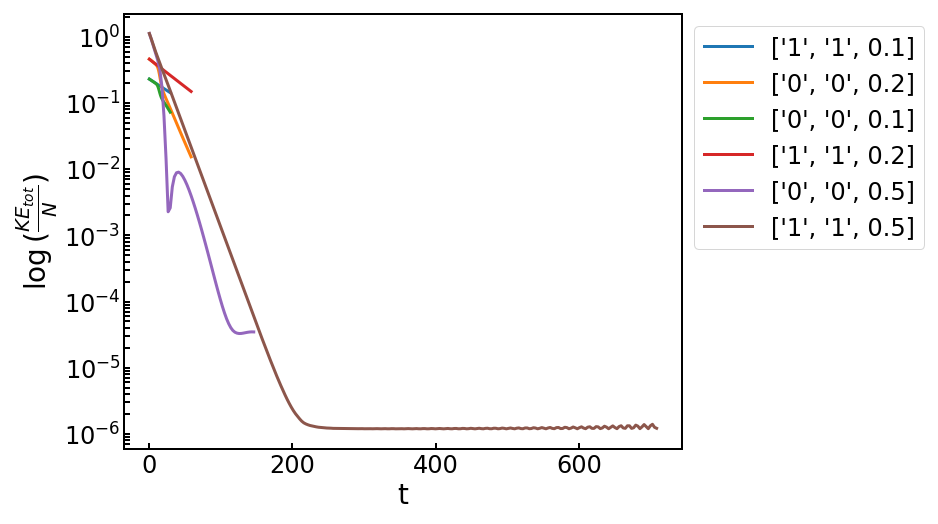

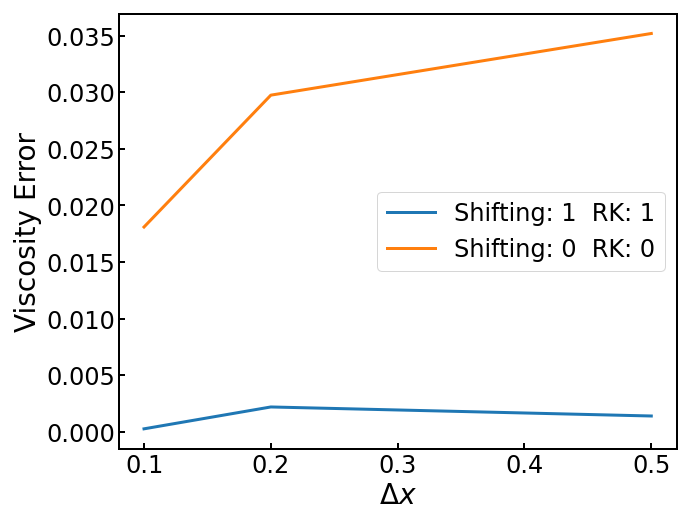

In [23]:
filepath = '/home/epalermo/dev/test/taylor_green_3D/data_files_omit_unstable'
data_files = generate_file_names(filepath)
all_run_info = benchmark_runs(data_files)
df = pd.DataFrame(all_run_info, columns=["Shifting","RK","sf","Viscosity Error"])
df.sort_values(by=["sf"], inplace=True)

fig = plt.figure()

for i in df["Shifting"].unique():
    df_1 = df[df["Shifting"]==i]
    for j in df_1["RK"].unique():
        df_2 = df_1[df_1["RK"]==j]
        label = "Shifting: " + i + "  " +"RK: " + j
        plt.plot(df_2["sf"],df_2["Viscosity Error"],label=label)
        print(df_2)
        
plt.legend()
plt.ylabel('Viscosity Error')
plt.xlabel(r"${\Delta x}$")

403
234.50000000000026 0.0
244
283.49999999999983 0.0
172
249.3750000000001 0.0
138
399.58333333333246 0.0
  Shifting RK    sf  Viscosity Error
0        1  1  0.10         0.000264
1        1  1  0.20         0.002186
2        1  1  0.25         0.004280
3        1  1  0.50         0.011956


Text(0.5, 0, '${\\Delta x}$')

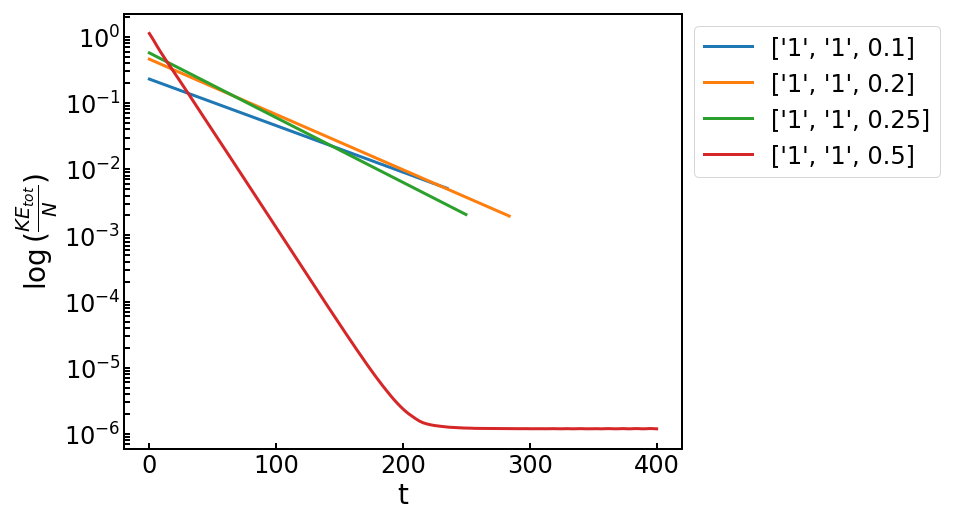

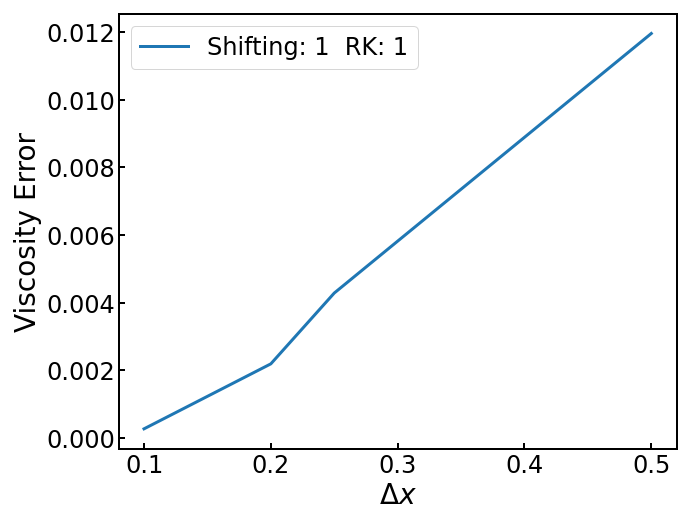

In [24]:
filepath = '/home/epalermo/dev/test/taylor_green_3D/data_files_variable_timesteps'
data_files = generate_file_names(filepath)
all_run_info = benchmark_runs(data_files)
df = pd.DataFrame(all_run_info, columns=["Shifting","RK","sf","Viscosity Error"])
df.sort_values(by=["sf"], inplace=True)

fig = plt.figure()

for i in df["Shifting"].unique():
    df_1 = df[df["Shifting"]==i]
    for j in df_1["RK"].unique():
        df_2 = df_1[df_1["RK"]==j]
        label = "Shifting: " + i + "  " +"RK: " + j
        plt.plot(df_2["sf"],df_2["Viscosity Error"],label=label)
        print(df_2)
        
plt.legend()
plt.ylabel('Viscosity Error')
plt.xlabel(r"${\Delta x}$")